Importing the libraries we'll be using 

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import PIL

import glob

from PIL import ImageDraw
from PIL import ImageColor
from PIL import ImageOps
from PIL import ImageFont

import matplotlib.pyplot as plt
from six.moves.urllib.request import urlopen
from six import BytesIO

%matplotlib inline

Creating a directory to store test images

In [ ]:
mkdir test_images

In [ ]:
cd test_images

/content/test_images


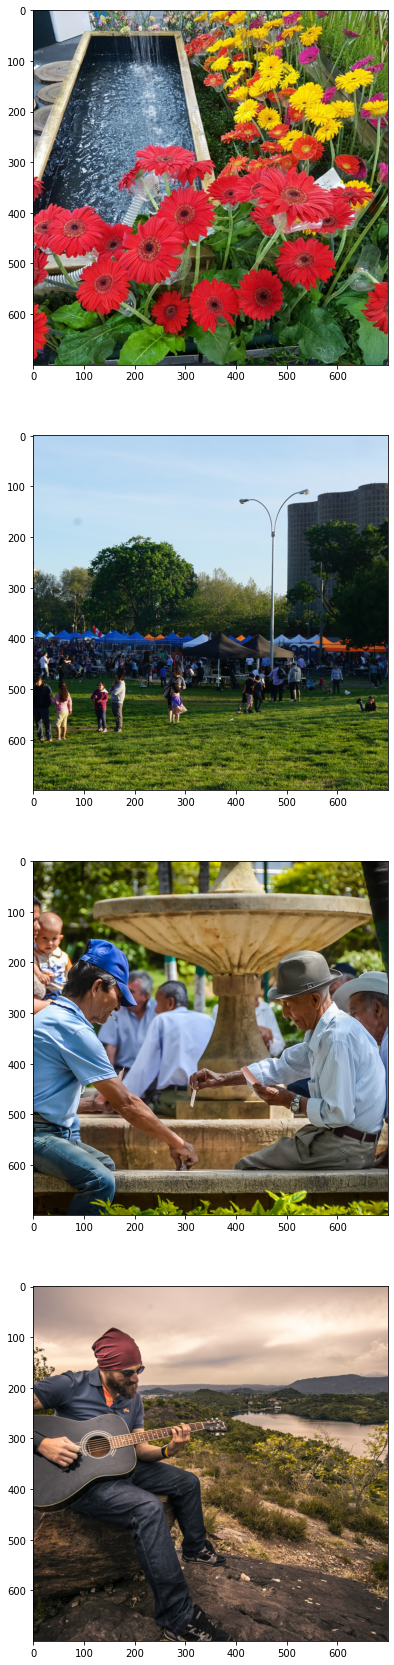

In [ ]:
test_img_urls = [
                 'https://upload.wikimedia.org/wikipedia/commons/9/94/2018_Goyang_International_Flower_Festival_3.jpg',
                 'https://upload.wikimedia.org/wikipedia/commons/e/e1/QueensNightMarket_May2019.jpg',
                 'https://upload.wikimedia.org/wikipedia/commons/0/06/Tarde_de_cartas.jpg',
                 'https://upload.wikimedia.org/wikipedia/commons/0/00/Landscape-nature-man-person_%2824298497756%29.jpg'
]

num_imgs = len(test_img_urls)

fig,subplots = plt.subplots(num_imgs,figsize=(20,30))

for i in range(num_imgs):
  data = urlopen(test_img_urls[i]).read()
  data = BytesIO(data)
  image = PIL.Image.open(data)
  image = ImageOps.fit(image, (700,700), PIL.Image.ANTIALIAS)
  image = image.convert("RGB")
  image.save(str(i+1)+'.jpg',format="JPEG")
  subplots[i].grid(False)
  subplots[i].imshow(image)



Writing functions to draw on the image.

In [ ]:
def draw_box(image,box,text,color):
  '''Draws a single box on the image'''

  #image will be a PIL image object
  #box will be an array of pixel values representing the top, left, bottom and right borders respectively
  #text will be the string value to display above the localized object.

  drawing = ImageDraw.Draw(image)
  top, left, bottom, right = box
  w, h = image.size
  font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",25)

  drawing.rectangle([(left,top),(right,bottom)], width=4, outline=color)
  drawing.rectangle([(left,top),(left+w//5,top+h//25)], fill=color)
  drawing.text([left,top],text,color='black',fill='black',font=font)



def localize_objects(image,boxes,labels,scores):
  '''Draws boxes around all the objects detected'''

  #image will be a PIL image object
  #boxes, labels, and scores will be numpy arrays

  class_to_color = dict()
  colors = list(ImageColor.colormap.keys())  #get list of colors which can be used
  c = len(colors)

  for i in range(1,len(labels)+1):           #create label mapping - each class gets a color from the list
    if labels[i-1] not in class_to_color:
     class_to_color[labels[i-1]] = colors[c%i]

  for i in range(len(boxes)):
    if scores[i]>0.5:
      text = "%s %.2f%%" % (labels[i],scores[i]*100)
      draw_box(image,boxes[i],text,class_to_color[labels[i]])



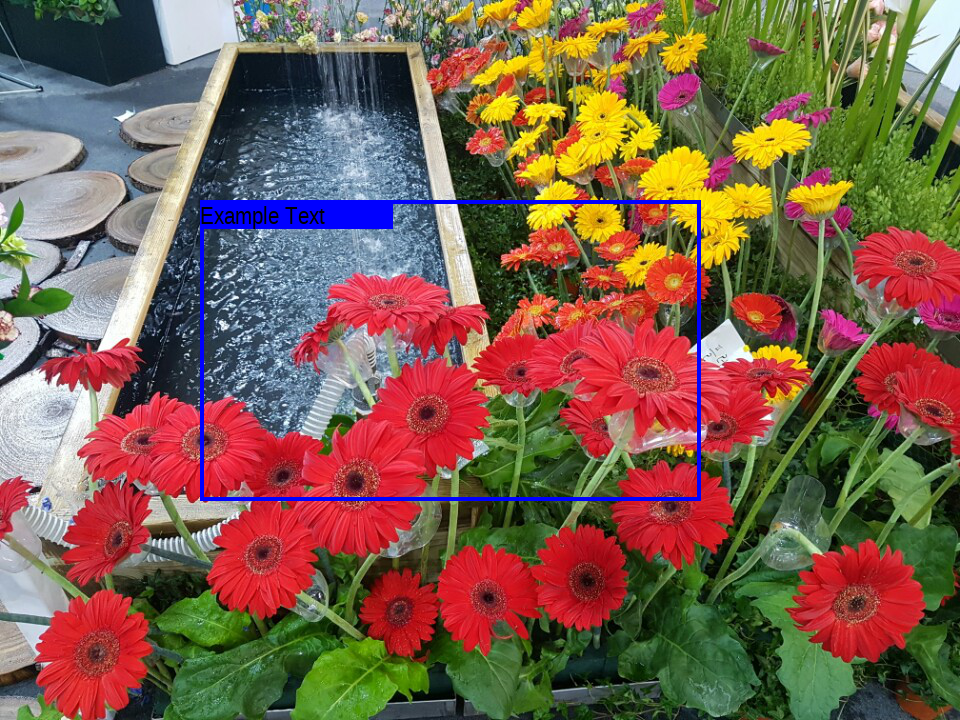

In [ ]:
data = urlopen(test_img_urls[0]).read()
data = BytesIO(data)
image = PIL.Image.open(data)
image = image.convert("RGB")

draw_box(image,[200,200,500,700],'Example Text','blue')
image

In [ ]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" 

#module_handle = 'https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1'

#module_handle = 'https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1'

detector = hub.load(module_handle)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
for b in detector.signatures:
  print(b)

default


In [ ]:
detector = detector.signatures['default']

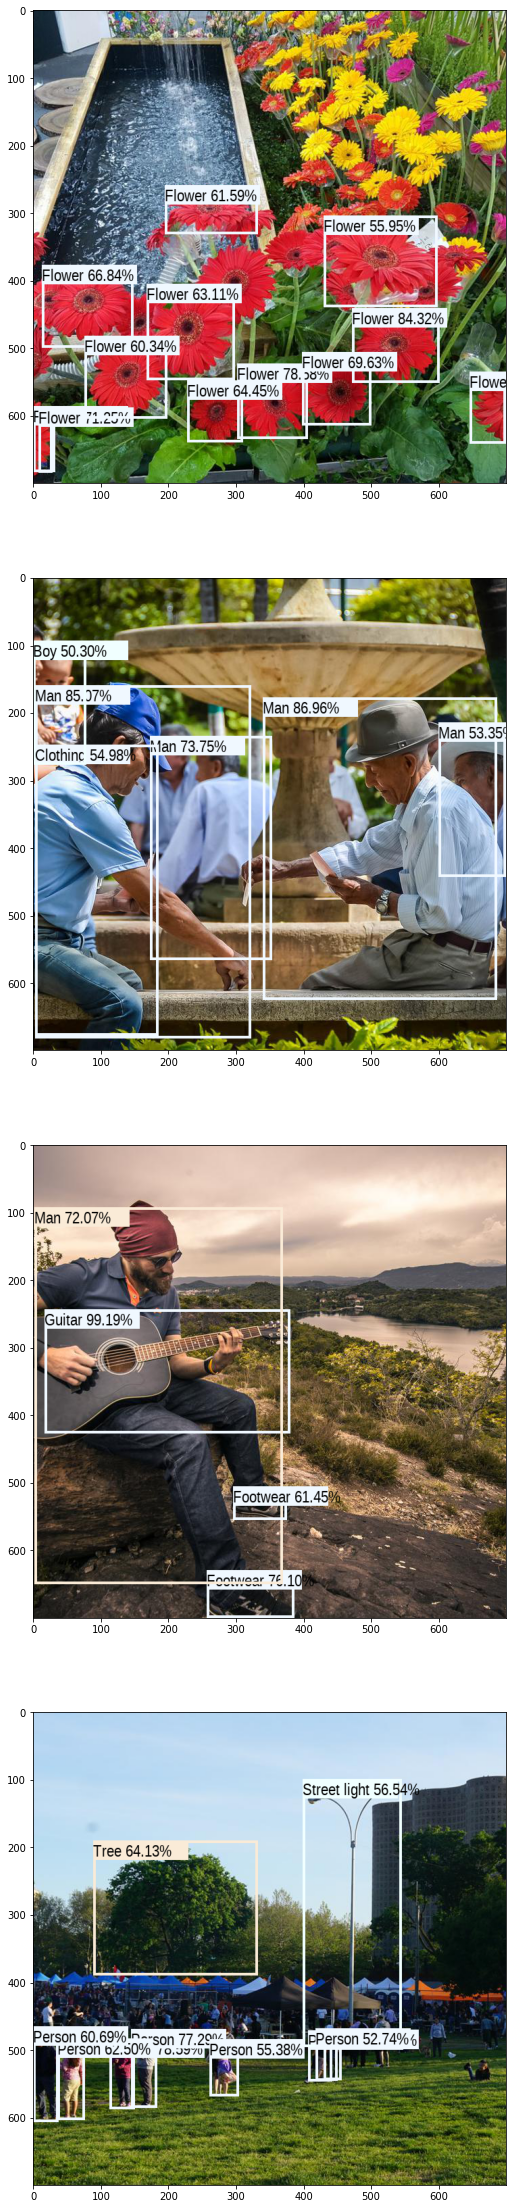

In [ ]:
#get list of filenames
test_img_paths = glob.glob('*.jpg')

fig,subplots = plt.subplots(num_imgs,figsize=(40,10*num_imgs))

for i in range(num_imgs):

  path = test_img_paths[i]

  tf_image = tf.image.decode_jpeg(tf.io.read_file(path),channels=3)
  tf_image = tf.image.convert_image_dtype(tf_image,tf.float32)[tf.newaxis, ...]

  detected_results = detector(tf_image)

  labels = list(map(lambda x: x.decode('utf-8'),detected_results['detection_class_entities'].numpy()))
  scores = detected_results['detection_scores'].numpy()

  pil_image = PIL.Image.open(path)
  width, height = pil_image.size

  boxes = list(map(
      lambda box: [box[0]*height,box[1]*width,box[2]*height,box[3]*width],
      detected_results['detection_boxes']
  ))

  localize_objects(pil_image,boxes,labels,scores)

  subplots[i].imshow(pil_image)





**Documentation for some of the most used methods**

PIL's ImageDraw library : https://pillow.readthedocs.io/en/stable/reference/ImageDraw.html

TensorFlow's Object Detection API overview : https://www.tensorflow.org/lite/examples/object_detection/overview

Tensorflow's Object Detection Tutorial : https://www.tensorflow.org/hub/tutorials/object_detection
